# Conversational Threads

Many LLM applications have a chatbot-like interface in which the user and the LLM application engage in a multi-turn conversation. In order to track these conversations, you can use the Threads feature in LangSmith.

This is relevant to our RAG application, which should maintain context from prior conversations with users.

### Setup

In [1]:
# Or you can use a .env file
from dotenv import load_dotenv
load_dotenv(override=True)

True

### Group traces into threads


A Thread is a sequence of traces representing a single conversation. Each response is represented as its own trace, but these traces are linked together by being part of the same thread.

To associate traces together, you need to pass in a special metadata key where the value is the unique identifier for that thread.

The key value is the unique identifier for that conversation. The key name should be one of:

- session_id
- thread_id
- conversation_id.

The value should be a UUID.

In [8]:
import uuid
thread_id = uuid.uuid4()

In [9]:
from langsmith import traceable
from openai import OpenAI
from typing import List
import nest_asyncio
from utils import get_vector_db_retriever

openai_client = OpenAI()
nest_asyncio.apply()
retriever = get_vector_db_retriever()

@traceable(run_type="chain")
def retrieve_documents(question: str):
    return retriever.invoke(question)

@traceable(run_type="chain")
def generate_response(question: str, documents):
    formatted_docs = "\n\n".join(doc.page_content for doc in documents)
    rag_system_prompt = """You are an assistant for question-answering tasks. 
    Use the following pieces of retrieved context to answer the latest question in the conversation. 
    If you don't know the answer, just say that you don't know. 
    Use three sentences maximum and keep the answer concise.
    """
    messages = [
        {
            "role": "system",
            "content": rag_system_prompt
        },
        {
            "role": "user",
            "content": f"Context: {formatted_docs} \n\n Question: {question}"
        }
    ]
    return call_openai(messages)

@traceable(run_type="llm")
def call_openai(
    messages: List[dict], model: str = "gpt-4o-mini", temperature: float = 0.0
) -> str:
    return openai_client.chat.completions.create(
        model=model,
        messages=messages,
        temperature=temperature,
    )

@traceable(run_type="chain")
def langsmith_rag(question: str):
    documents = retrieve_documents(question)
    response = generate_response(question, documents)
    return response.choices[0].message.content


### Now let's run our application twice with this thread_id

In [10]:
question = "How do I add metadata to a Trace?"
ai_answer = langsmith_rag(question, langsmith_extra={"metadata": {"thread_id": thread_id}})
print(ai_answer)

To add metadata to a trace in LangSmith, you need to include a dictionary of key-value pairs when creating the trace. This metadata can store additional information about the trace, such as the environment or user details. Ensure that the same metadata is also attached to the corresponding run for better tracking and analysis.


In [11]:
question = "How can I add tags to a Trace?"
ai_answer = langsmith_rag(question, langsmith_extra={"metadata": {"thread_id": thread_id}})
print(ai_answer)

You can add tags to a trace in LangSmith by sending arbitrary metadata and tags along with the trace. Tags are strings used to categorize or label the trace, while metadata is a dictionary of key-value pairs for additional information. For detailed instructions, refer to the documentation on adding metadata and tags to traces.


### We formed a thread, which makes up a chat interface, where users questions and the responses to it are shown. Each input from the user forms a new trace and all these traces are bundled up together in a thread which gives us that chat interface type of look.

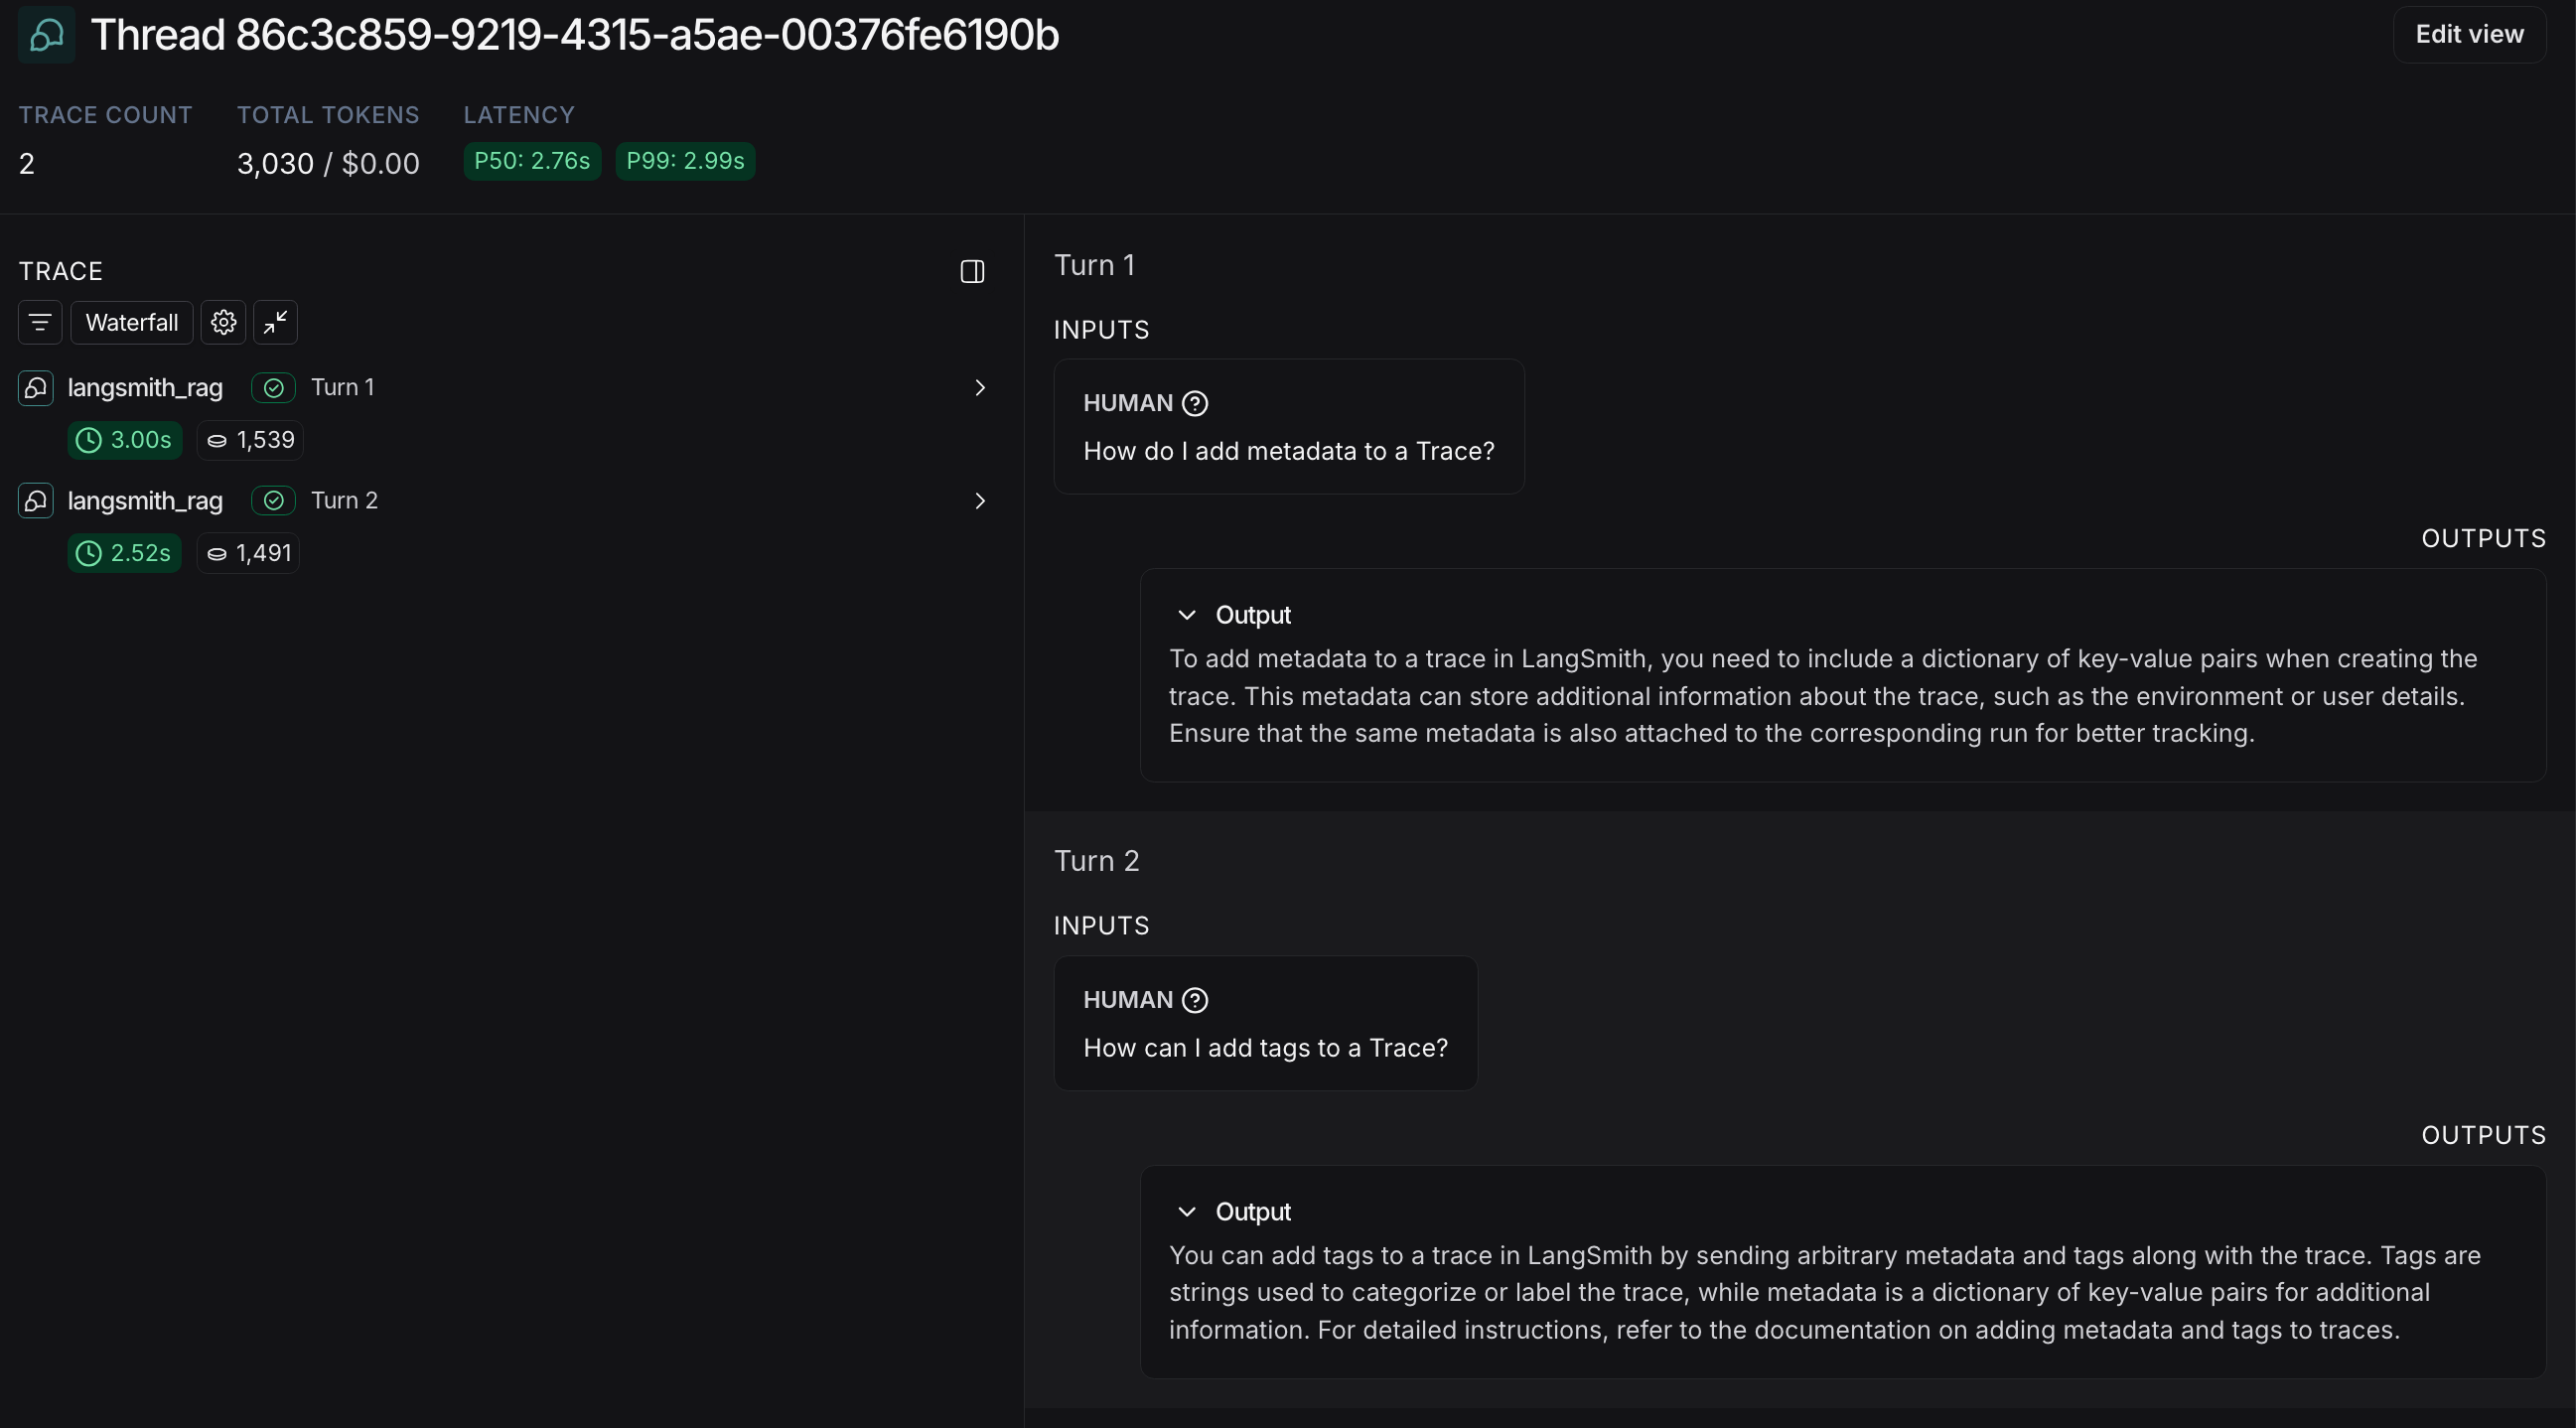

### Let's take a look in LangSmith!

# SELF-EXERCISE:

In [12]:
question = "How do traces help debug unexpected outputs from a model?"
ai_answer = langsmith_rag(question, langsmith_extra={"metadata": {"thread_id": thread_id}})
print(ai_answer)

Traces help debug unexpected outputs by providing detailed logs of the model's inputs and outputs, allowing developers to analyze the flow of data and identify where issues may have occurred. They also enable filtering and querying of trace data, making it easier to navigate through large amounts of information. By examining these traces, developers can pinpoint discrepancies and improve the model's performance.


In [13]:
question = "What parts of an LLM pipeline should I trace?"
ai_answer = langsmith_rag(question, langsmith_extra={"metadata": {"thread_id": thread_id}})
print(ai_answer)

You should trace the individual responses generated by the LLM, as well as any interactions that occur during the conversation, such as user inputs and tool calls. Additionally, logging metadata related to the conversation, like unique identifiers for threads, can help in organizing and analyzing the traces effectively. This will provide a comprehensive view of the LLM's performance and decision-making process throughout the pipeline.


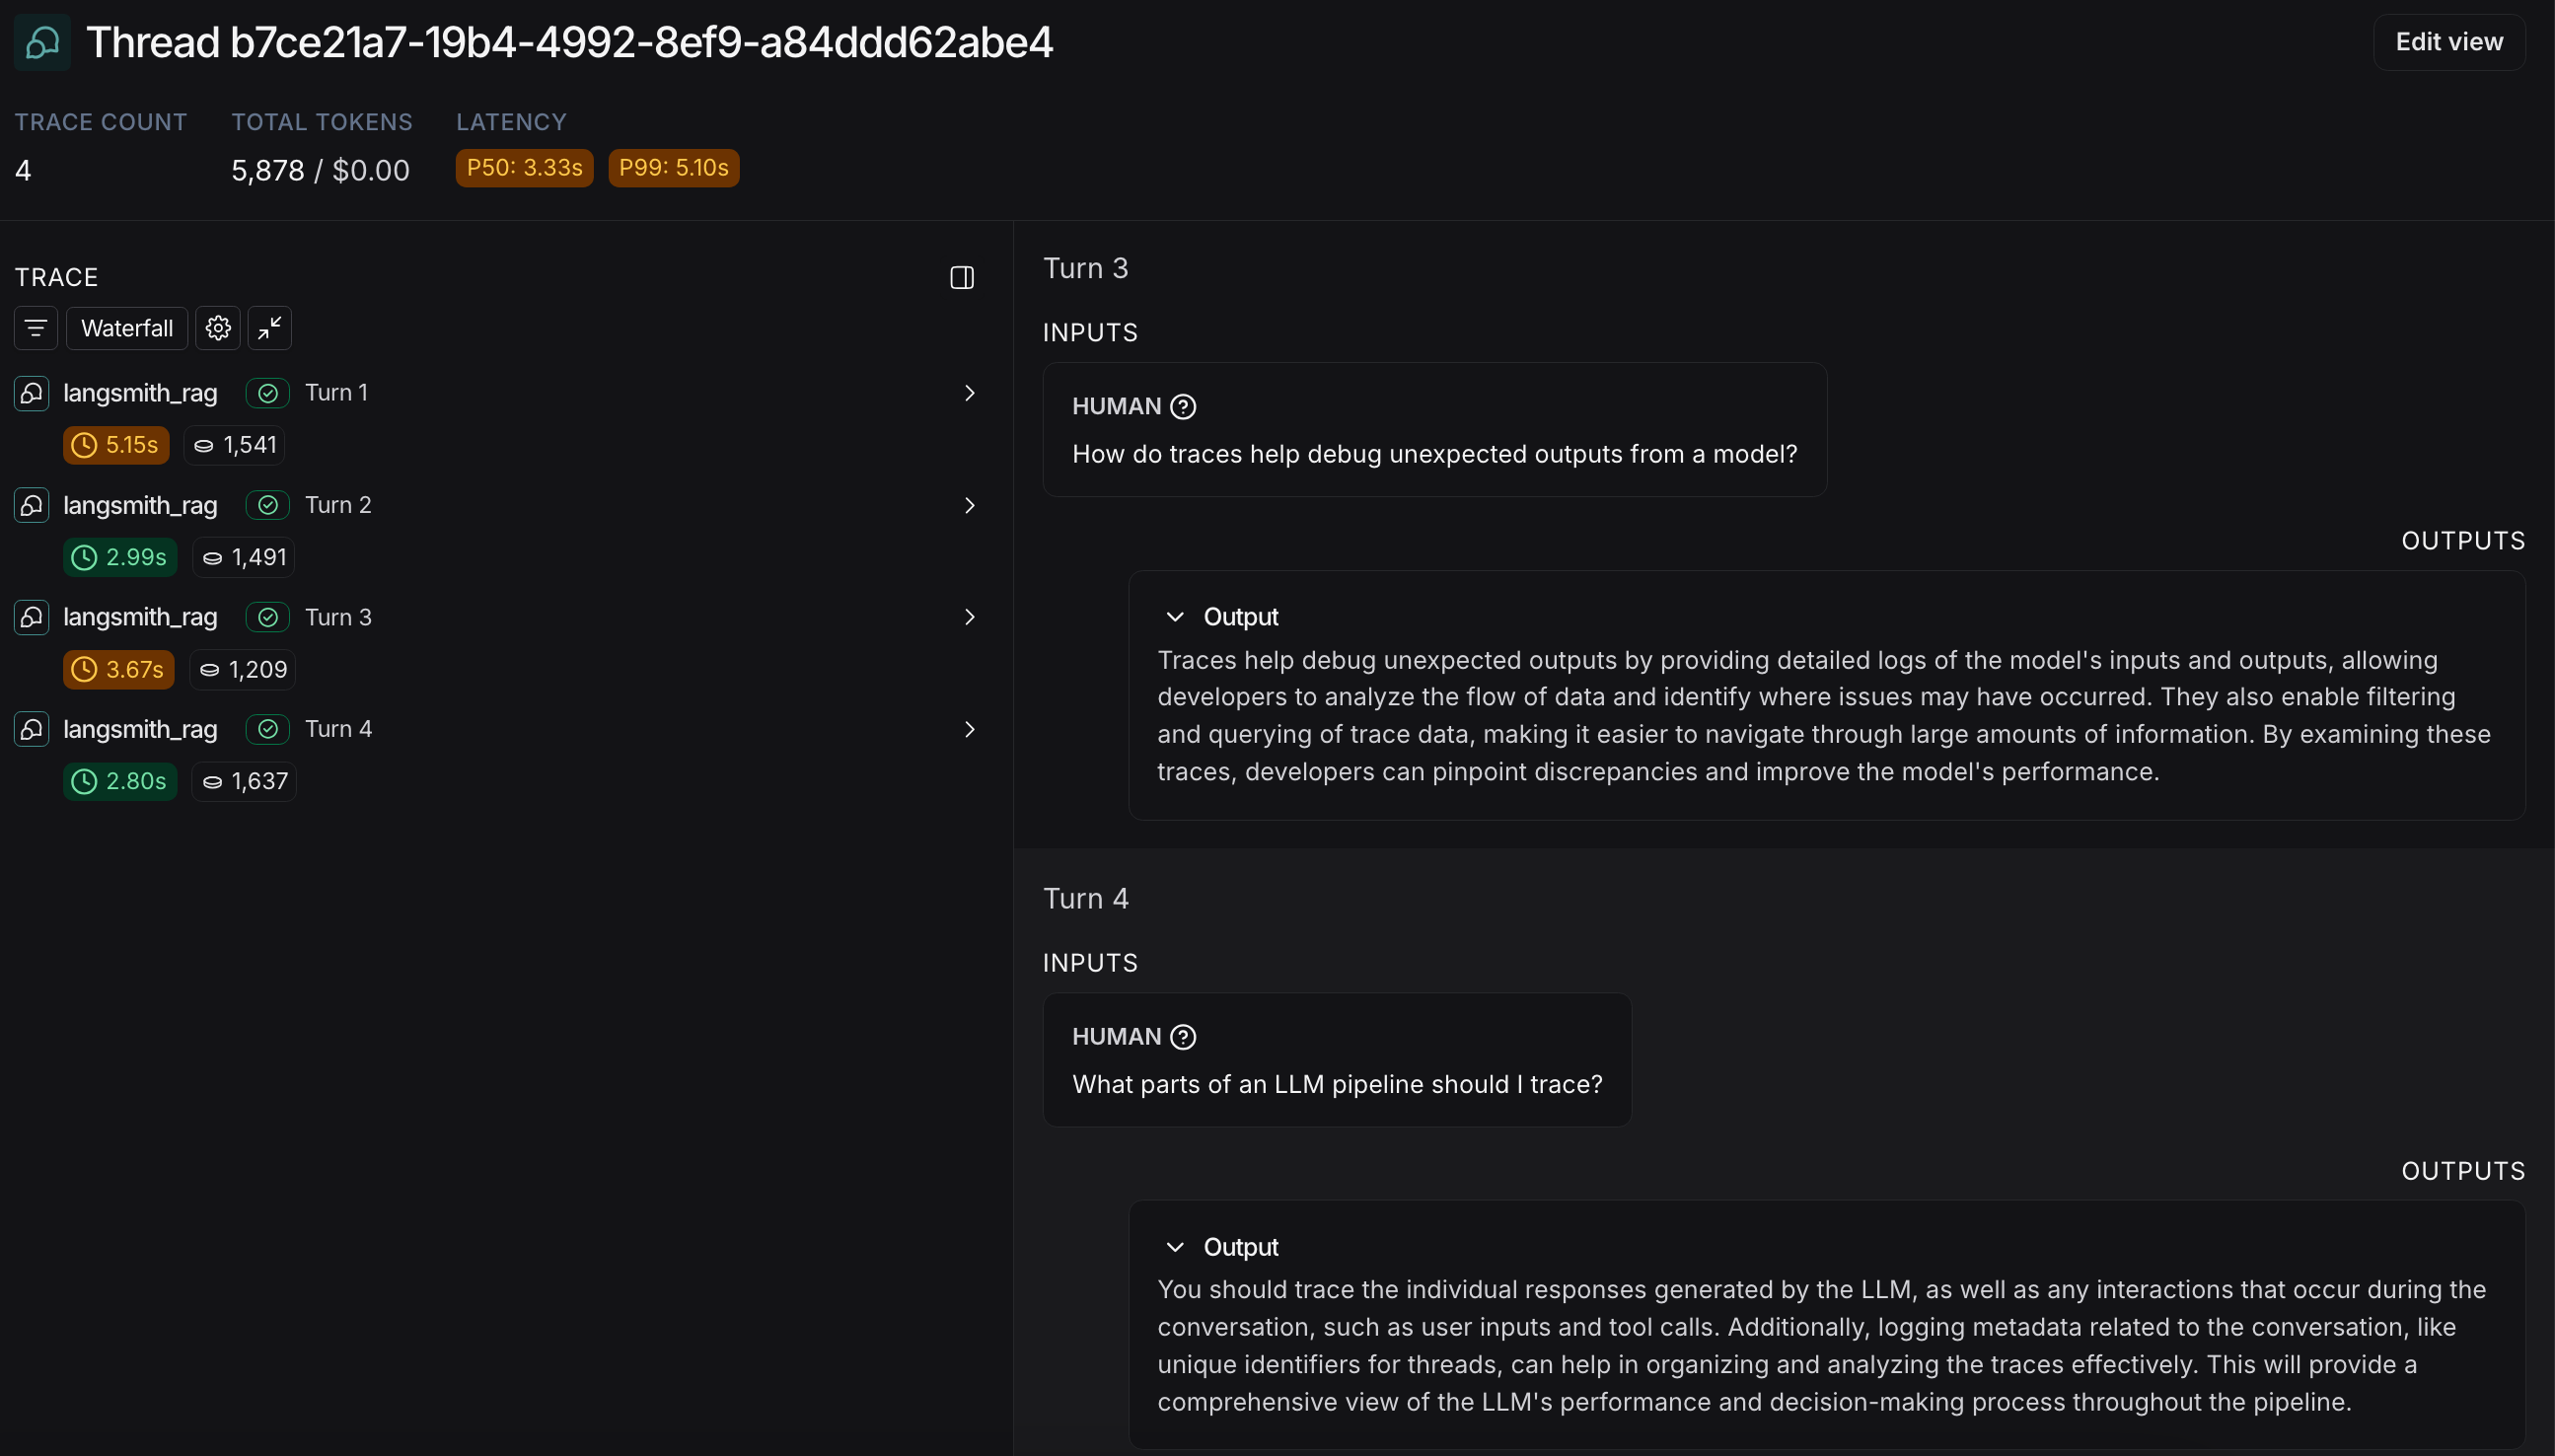